In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set_theme()

In [29]:
# Get a list of all files which are .csv files in ../DOTSSimulator/Assets/SimulationResults
import os

def get_avg_hrs_per_day(nofish: str) -> float:
    files = [f for f in os.listdir(f'./results/{nofish}') if f.endswith('.csv')]
    # Sort the files descending
    files.sort(reverse=True)

    print(f'Found {len(files)} files')
    print(f'Newest file: {files[0]}')

    compute_times = []
    for f in files:
        result_file_path = f'./results/{nofish}/{f}'
        results_df: pd.DataFrame = pd.read_csv(result_file_path)
        # Print basic information about the dataframe
        # print(results_df.info())

        results_df['DistanceFromLast'] = results_df['TimeStamp'].diff()
        truncated_df = results_df.iloc[1:25]


        # print(truncated_df.describe())

        # print(truncated_df.head())

        compute_times.extend(truncated_df['DistanceFromLast'].to_numpy())

    return np.mean(compute_times), np.std(compute_times)

In [30]:
configs = [1,5,10,25,50,100,200,300,500,750,1000]

means = []
stds = []
for config in configs:
    mean, std = get_avg_hrs_per_day(str(config))
    means.append(mean)
    stds.append(std)

results_df = pd.DataFrame({'NumberOfFish': configs, 'Mean': means, 'Std': stds})
results_df['min_std'] = results_df['Mean'] - results_df['Std']
results_df['max_std'] = results_df['Mean'] + results_df['Std']

results_df

Found 5 files
Newest file: 2023-07-29-18-56-29.csv
Found 5 files
Newest file: 2023-07-29-19-21-14.csv
Found 5 files
Newest file: 2023-07-29-21-06-58.csv
Found 5 files
Newest file: 2023-07-29-21-36-11.csv
Found 5 files
Newest file: 2023-07-29-22-08-18.csv
Found 5 files
Newest file: 2023-07-29-22-34-36.csv
Found 5 files
Newest file: 2023-07-29-23-22-06.csv
Found 5 files
Newest file: 2023-07-30-11-09-50.csv
Found 5 files
Newest file: 2023-07-30-13-52-45.csv
Found 5 files
Newest file: 2023-07-30-18-43-57.csv
Found 5 files
Newest file: 2023-07-30-21-38-24.csv


,NumberOfFish,Mean,Std,min_std,max_std
0,1,3.263840,0.029798,3.234043,3.293638
1,5,3.391375,0.018956,3.372419,3.410331
2,10,3.587914,0.021662,3.566252,3.609576
3,25,4.250842,0.031659,4.219183,4.282500
4,50,6.322380,0.092525,6.229855,6.414905
5,100,10.940633,0.154598,10.786036,11.095231
6,200,21.465471,0.136556,21.328914,21.602027
7,300,32.909386,0.440034,32.469352,33.349420
8,500,55.804242,1.481041,54.323201,57.285283
9,750,85.521687,2.028483,83.493204,87.550170


In [31]:
diff_for_4_fish = (results_df.iloc[1]['Mean'] - results_df.iloc[0]['Mean']) / 4
base_cost = results_df.iloc[0]['Mean'] - diff_for_4_fish
cores = 16

expected_y = np.array([x / cores * diff_for_4_fish * (x - 1) * diff_for_4_fish + base_cost for x in configs])

results_df['expected_y'] = expected_y

results_df

,NumberOfFish,Mean,Std,min_std,max_std,expected_y
0,1,3.263840,0.029798,3.234043,3.293638,3.231957
1,5,3.391375,0.018956,3.372419,3.410331,3.233227
2,10,3.587914,0.021662,3.566252,3.609576,3.237675
3,25,4.250842,0.031659,4.219183,4.282500,3.270078
4,50,6.322380,0.092525,6.229855,6.414905,3.387619
5,100,10.940633,0.154598,10.786036,11.095231,3.860960
6,200,21.465471,0.136556,21.328914,21.602027,5.760678
7,300,32.909386,0.440034,32.469352,33.349420,8.931109
8,500,55.804242,1.481041,54.323201,57.285283,19.084115
9,750,85.521687,2.028483,83.493204,87.550170,38.923140


In [32]:
# Extend data with the previous benchmark experiment

old_results = pd.read_csv('../0 - Benchmarks/aggregated_results.csv')

results_df['previous_benchmark'] = old_results['Mean']

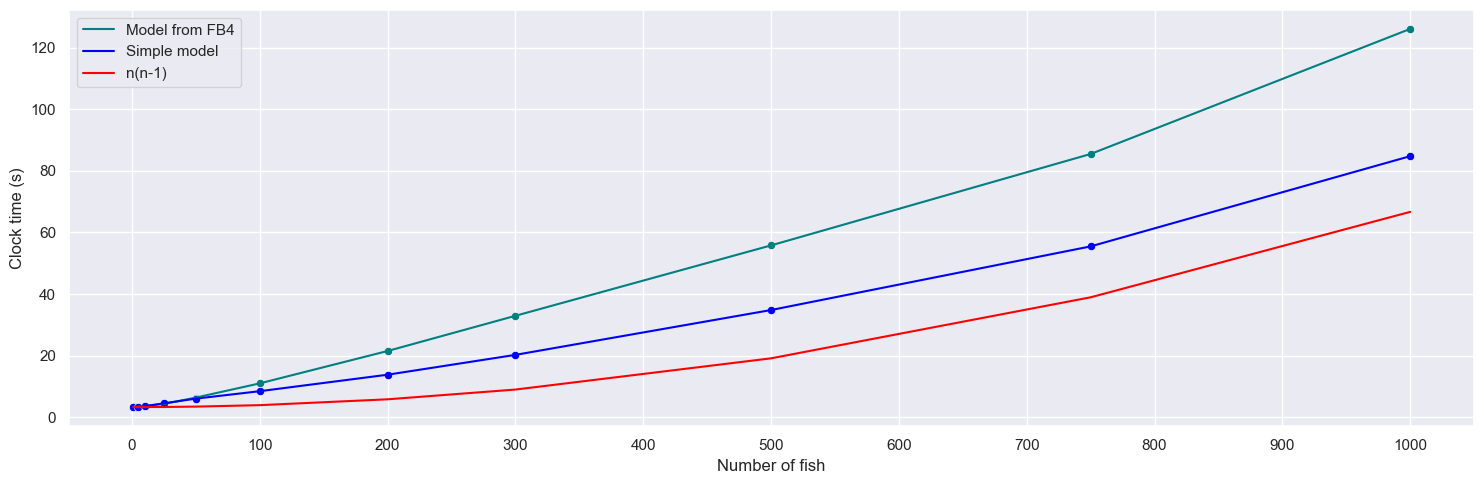

In [33]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot()
sns.scatterplot(data=results_df, x='NumberOfFish', y='Mean', color='teal', ax=ax)
sns.lineplot(data=results_df, x='NumberOfFish', y='Mean', color='teal', ax=ax, label='Model from FB4')
sns.lineplot(data=results_df, x='NumberOfFish', y='previous_benchmark', color='blue', ax=ax, label='Simple model')
sns.scatterplot(data=results_df, x='NumberOfFish', y='previous_benchmark', color='blue', ax=ax)
sns.lineplot(data=results_df, x='NumberOfFish', y='expected_y', color='red', ax=ax, label='n(n-1)')
plt.xticks(np.arange(0, 1001, 100))
plt.ylabel('Clock time (s)')
plt.xlabel('Number of fish')
plt.tight_layout()
 
plt.savefig('plots/benchmark-2.pdf')